In [1]:
! pwd

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/TSMO


In [2]:
%cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing


In [3]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import json

from shapely.geometry import  MultiLineString, mapping, shape
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import angle, check_direction

# 1. EDA of XD segments & TMC segments (in Howard shapefile)

### 1.1 File I/O

In [4]:
# TMC & XD Geometry Data
'''
'tmc', 'miles', 'direction', 'type_x', 'type_y', 'road_order',
       'roadname', 'roadnumber', 'county', 'state', 'zip', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude', 'geometry'
'''
gdf_TSMO_tmc = gpd.read_file("../data/shape/tmc_shape_TSMO/tmc_shape_TSMO_for_sjoin.geojson")  # 1591 TMC segments in TSMO (selected from Carroll, Howard and Baltimore) used for spatial join

'''
'xd', 'miles', 'direction', 'bearing', 'frc', 'roadname', 'roadnumer',
       'county', 'state', 'zip', 'start_latitude', 'start_longitude',
       'end_latitude', 'end_longitude', 'geometry'
'''
gdf_TSMO_xd = gpd.read_file("../data/shape/xd_shape_TSMO/xd_shape_TSMO_for_sjoin.geojson")  # 2501 XD segments in TSMO (selected from Carroll, Howard and Baltimore) used for spatial join

### 1.2 Visualization

<AxesSubplot: title={'center': 'Visualization of 1591 TSMO TMC Segments (Orange) and 2501 TSMO Segments (Blue)'}>

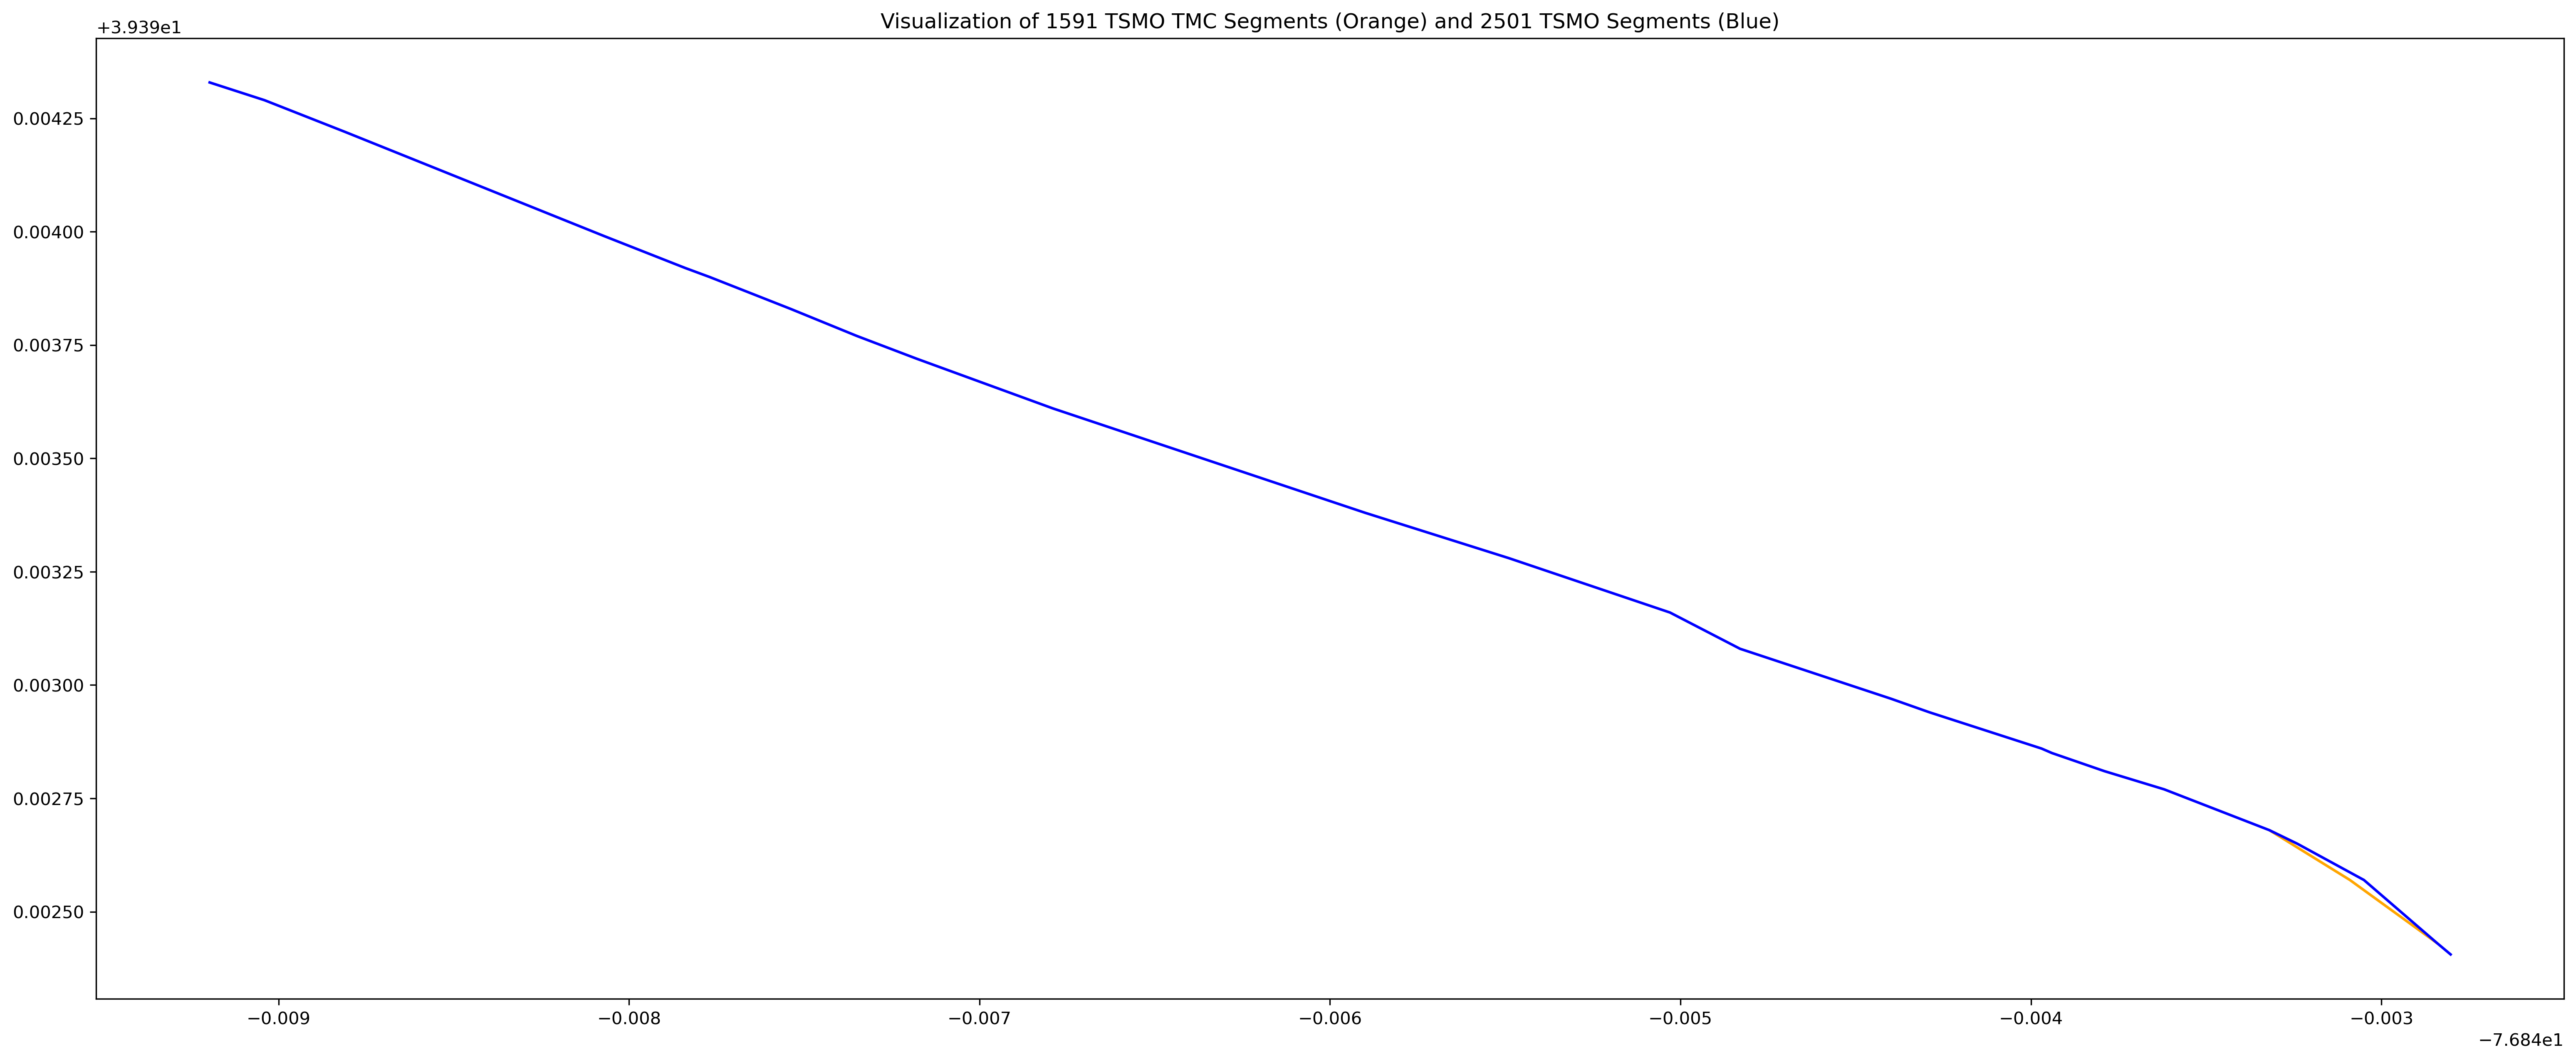

In [69]:
# (1) visualization of 1093 cranberry tmc segments
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of 1591 TSMO TMC Segments (Orange) and 2501 TSMO Segments (Blue)")
gdf_TSMO_tmc.plot(ax=ax, color="orange", alpha=0.5)
gdf_TSMO_xd.plot(ax=ax, color="blue", alpha=0.3)
# gdf_TSMO_tmc[gdf_TSMO_tmc.tmc == "110N05239"].plot(ax=ax, color="orange", alpha=1)
# gdf_TSMO_xd[gdf_TSMO_xd.xd == 133613798].plot(ax=ax, color="blue", alpha=1)
fig.savefig("./TSMO/viz_TSMO_tmc_xd.jpg")

# 2. Match TMC and XD Segments

### 2.1 Create Buffer for Segments
Since the geometry of TMC segments and those of XD segments may not be perfectly aligned with one another, i.e. there may well be a tiny gap/shift between a TMC-XD pair even though they are supposed to be matched, here a buffer is created for each segment. The size of buffer ("distance" as specified in syntax of geopandas function) is manually defined. 

In [10]:
gdf_TSMO_tmc_polygon = gdf_TSMO_tmc.copy()
gdf_TSMO_tmc_polygon["geometry"] = gdf_TSMO_tmc.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)
gdf_TSMO_tmc_polygon["area"] = gdf_TSMO_tmc_polygon["geometry"].to_crs({'proj':'cea'}).area  # in unit of square meter

gdf_TSMO_xd_polygon = gdf_TSMO_xd.copy()
gdf_TSMO_xd_polygon["geometry"] = gdf_TSMO_xd.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)
gdf_TSMO_xd_polygon["area"] = gdf_TSMO_xd_polygon["geometry"].to_crs({'proj':'cea'}).area  # in unit of square meter

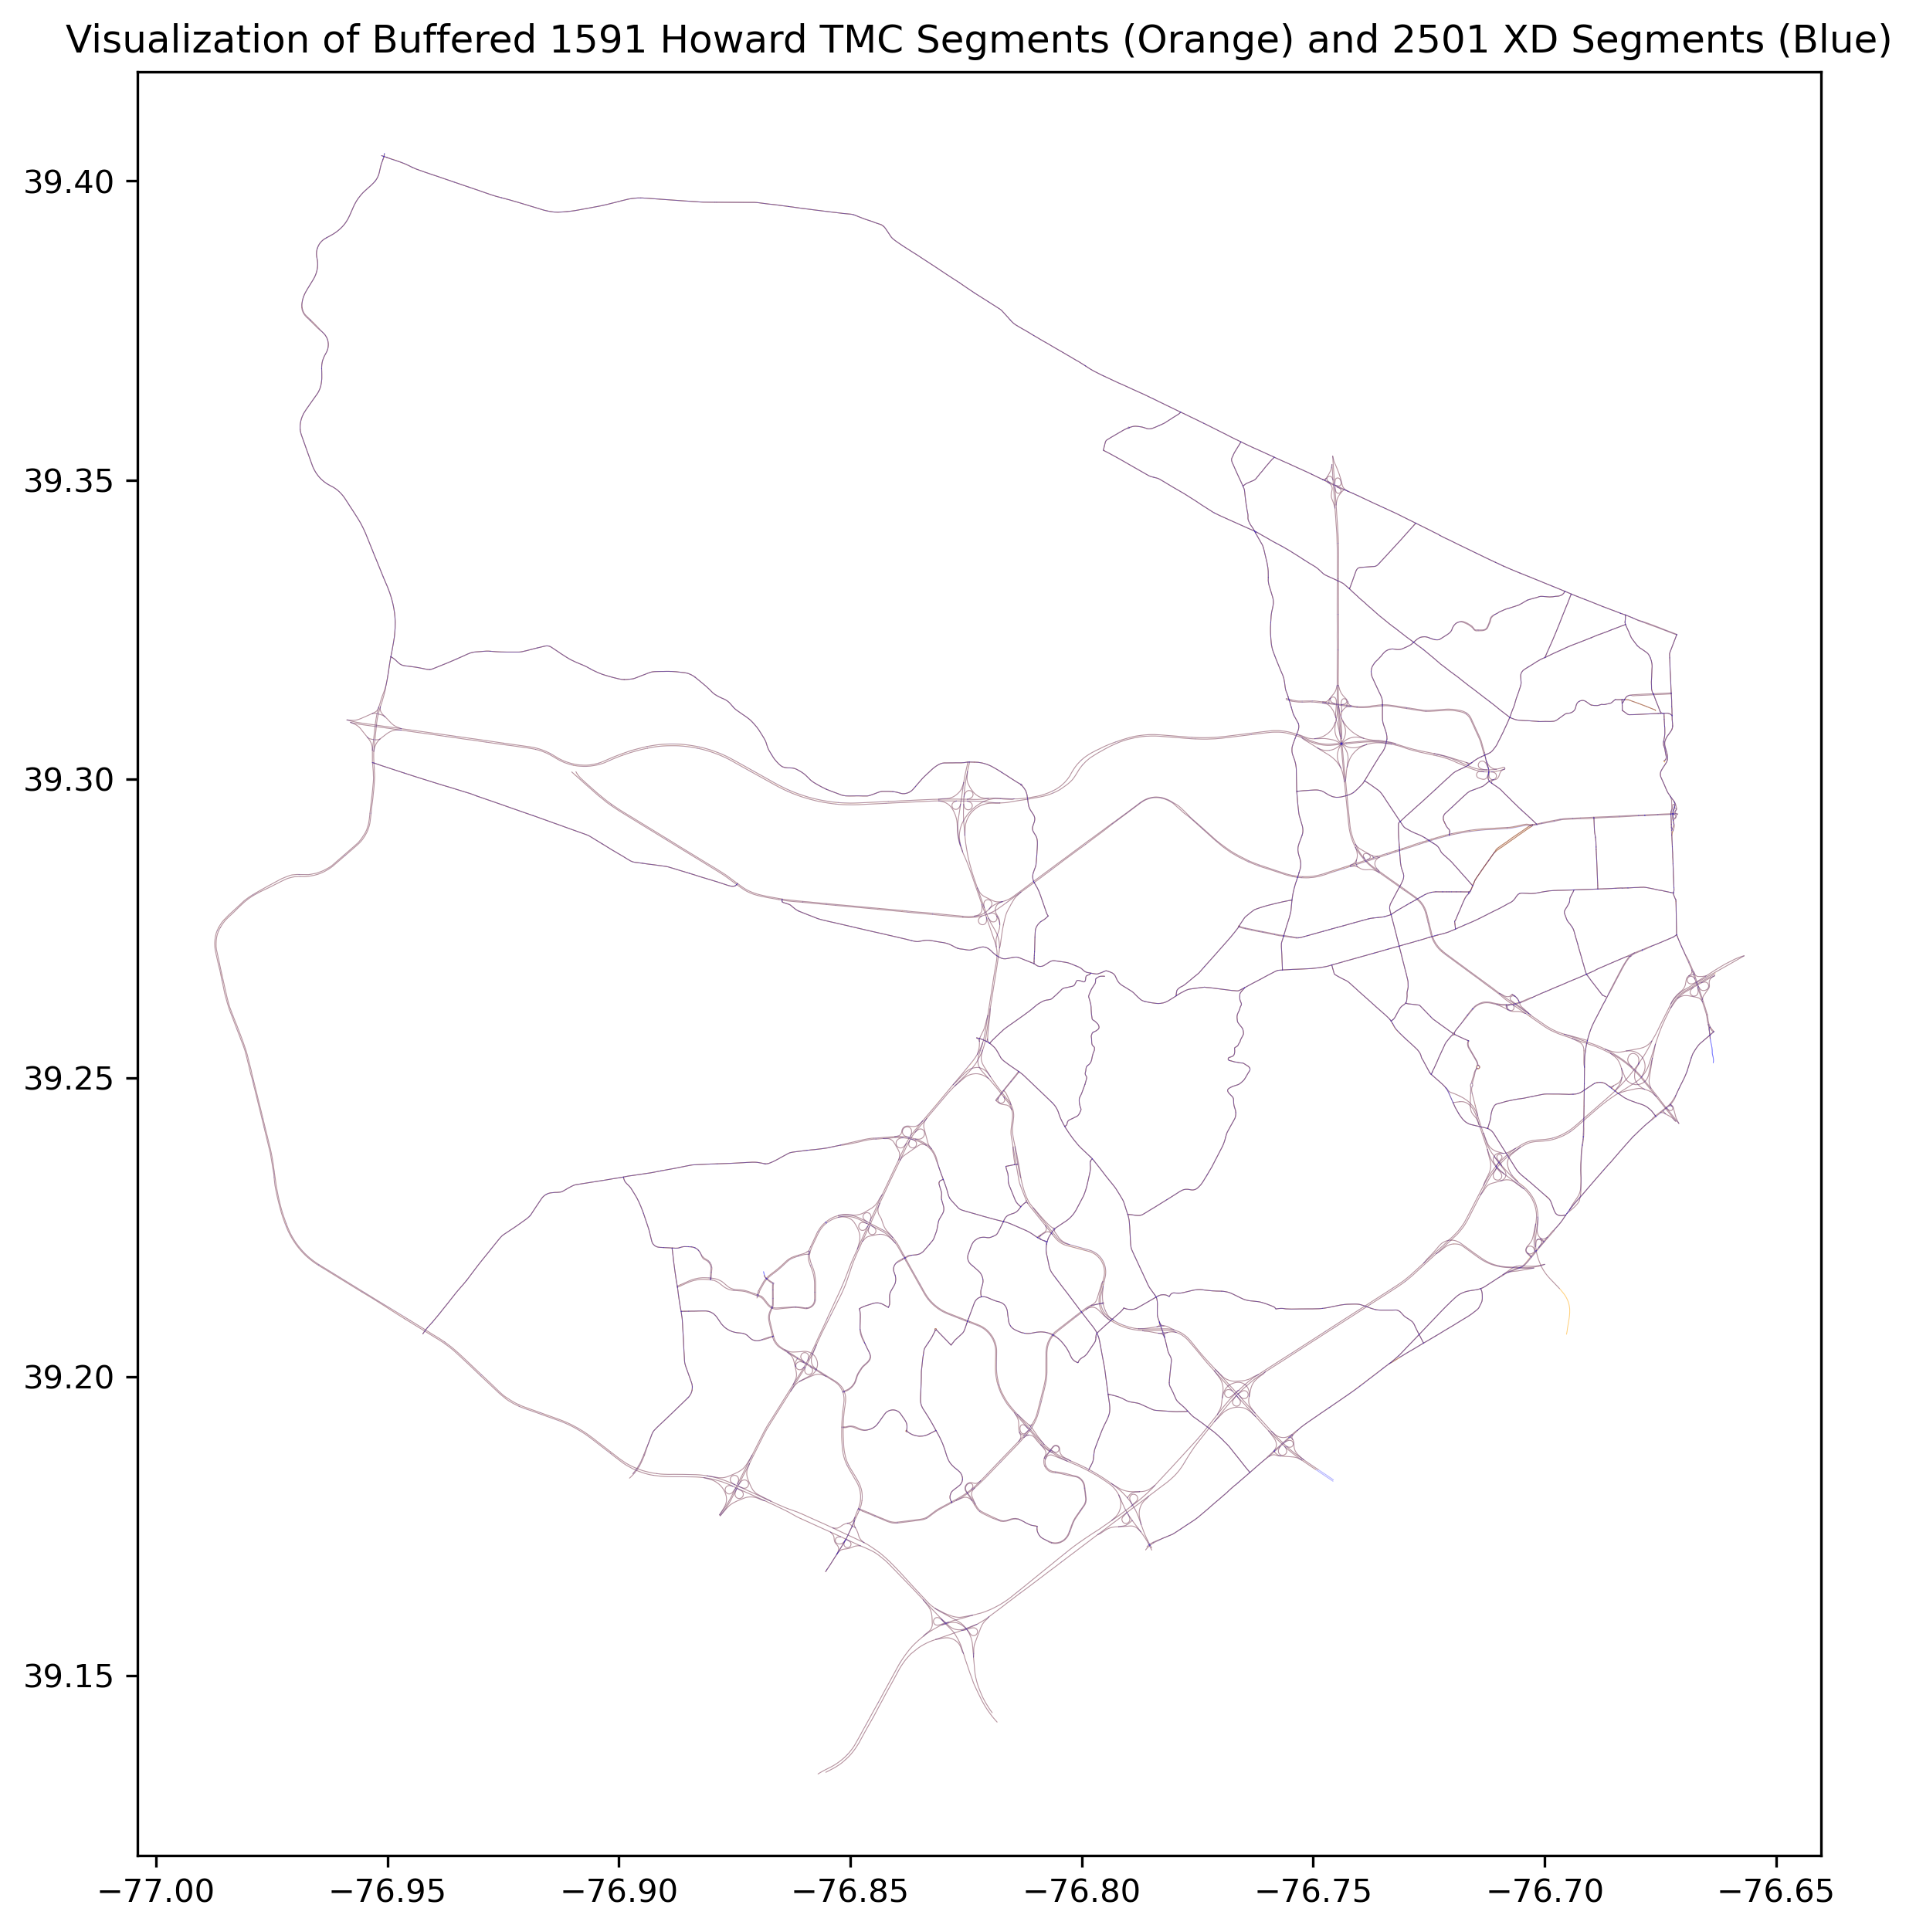

In [12]:
# Visualization of Buffered 1037 TMC (blue) and 1401 XD (yellow) Segments
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of Buffered 1591 Howard TMC Segments (Orange) and 2501 XD Segments (Blue)")
gdf_TSMO_tmc_polygon.plot(ax=ax, color="orange", alpha=0.5)
gdf_TSMO_xd_polygon.plot(ax=ax, color="blue", alpha=0.3)
fig.savefig("./TSMO/viz_TSMO_buffered_tmc_xd.jpg")

### 2.2 Spatial Join

In [13]:
# we would like to retain all tmc segments, therefore we do left join here
xd_to_tmc = gpd.overlay(df1=gdf_TSMO_tmc_polygon, df2=gdf_TSMO_xd_polygon, how="intersection") # 1591 TMC, 2501 XD, shape (12708, 36)

In [23]:
xd_to_tmc["overlap_area"] = xd_to_tmc["geometry"].to_crs({'proj':'cea'}).area

<AxesSubplot: title={'center': 'Visualization of Overlapping Area (Red) between 1591 Howard TMC Segments (Orange) and 2501 XD Segments (Blue)'}>

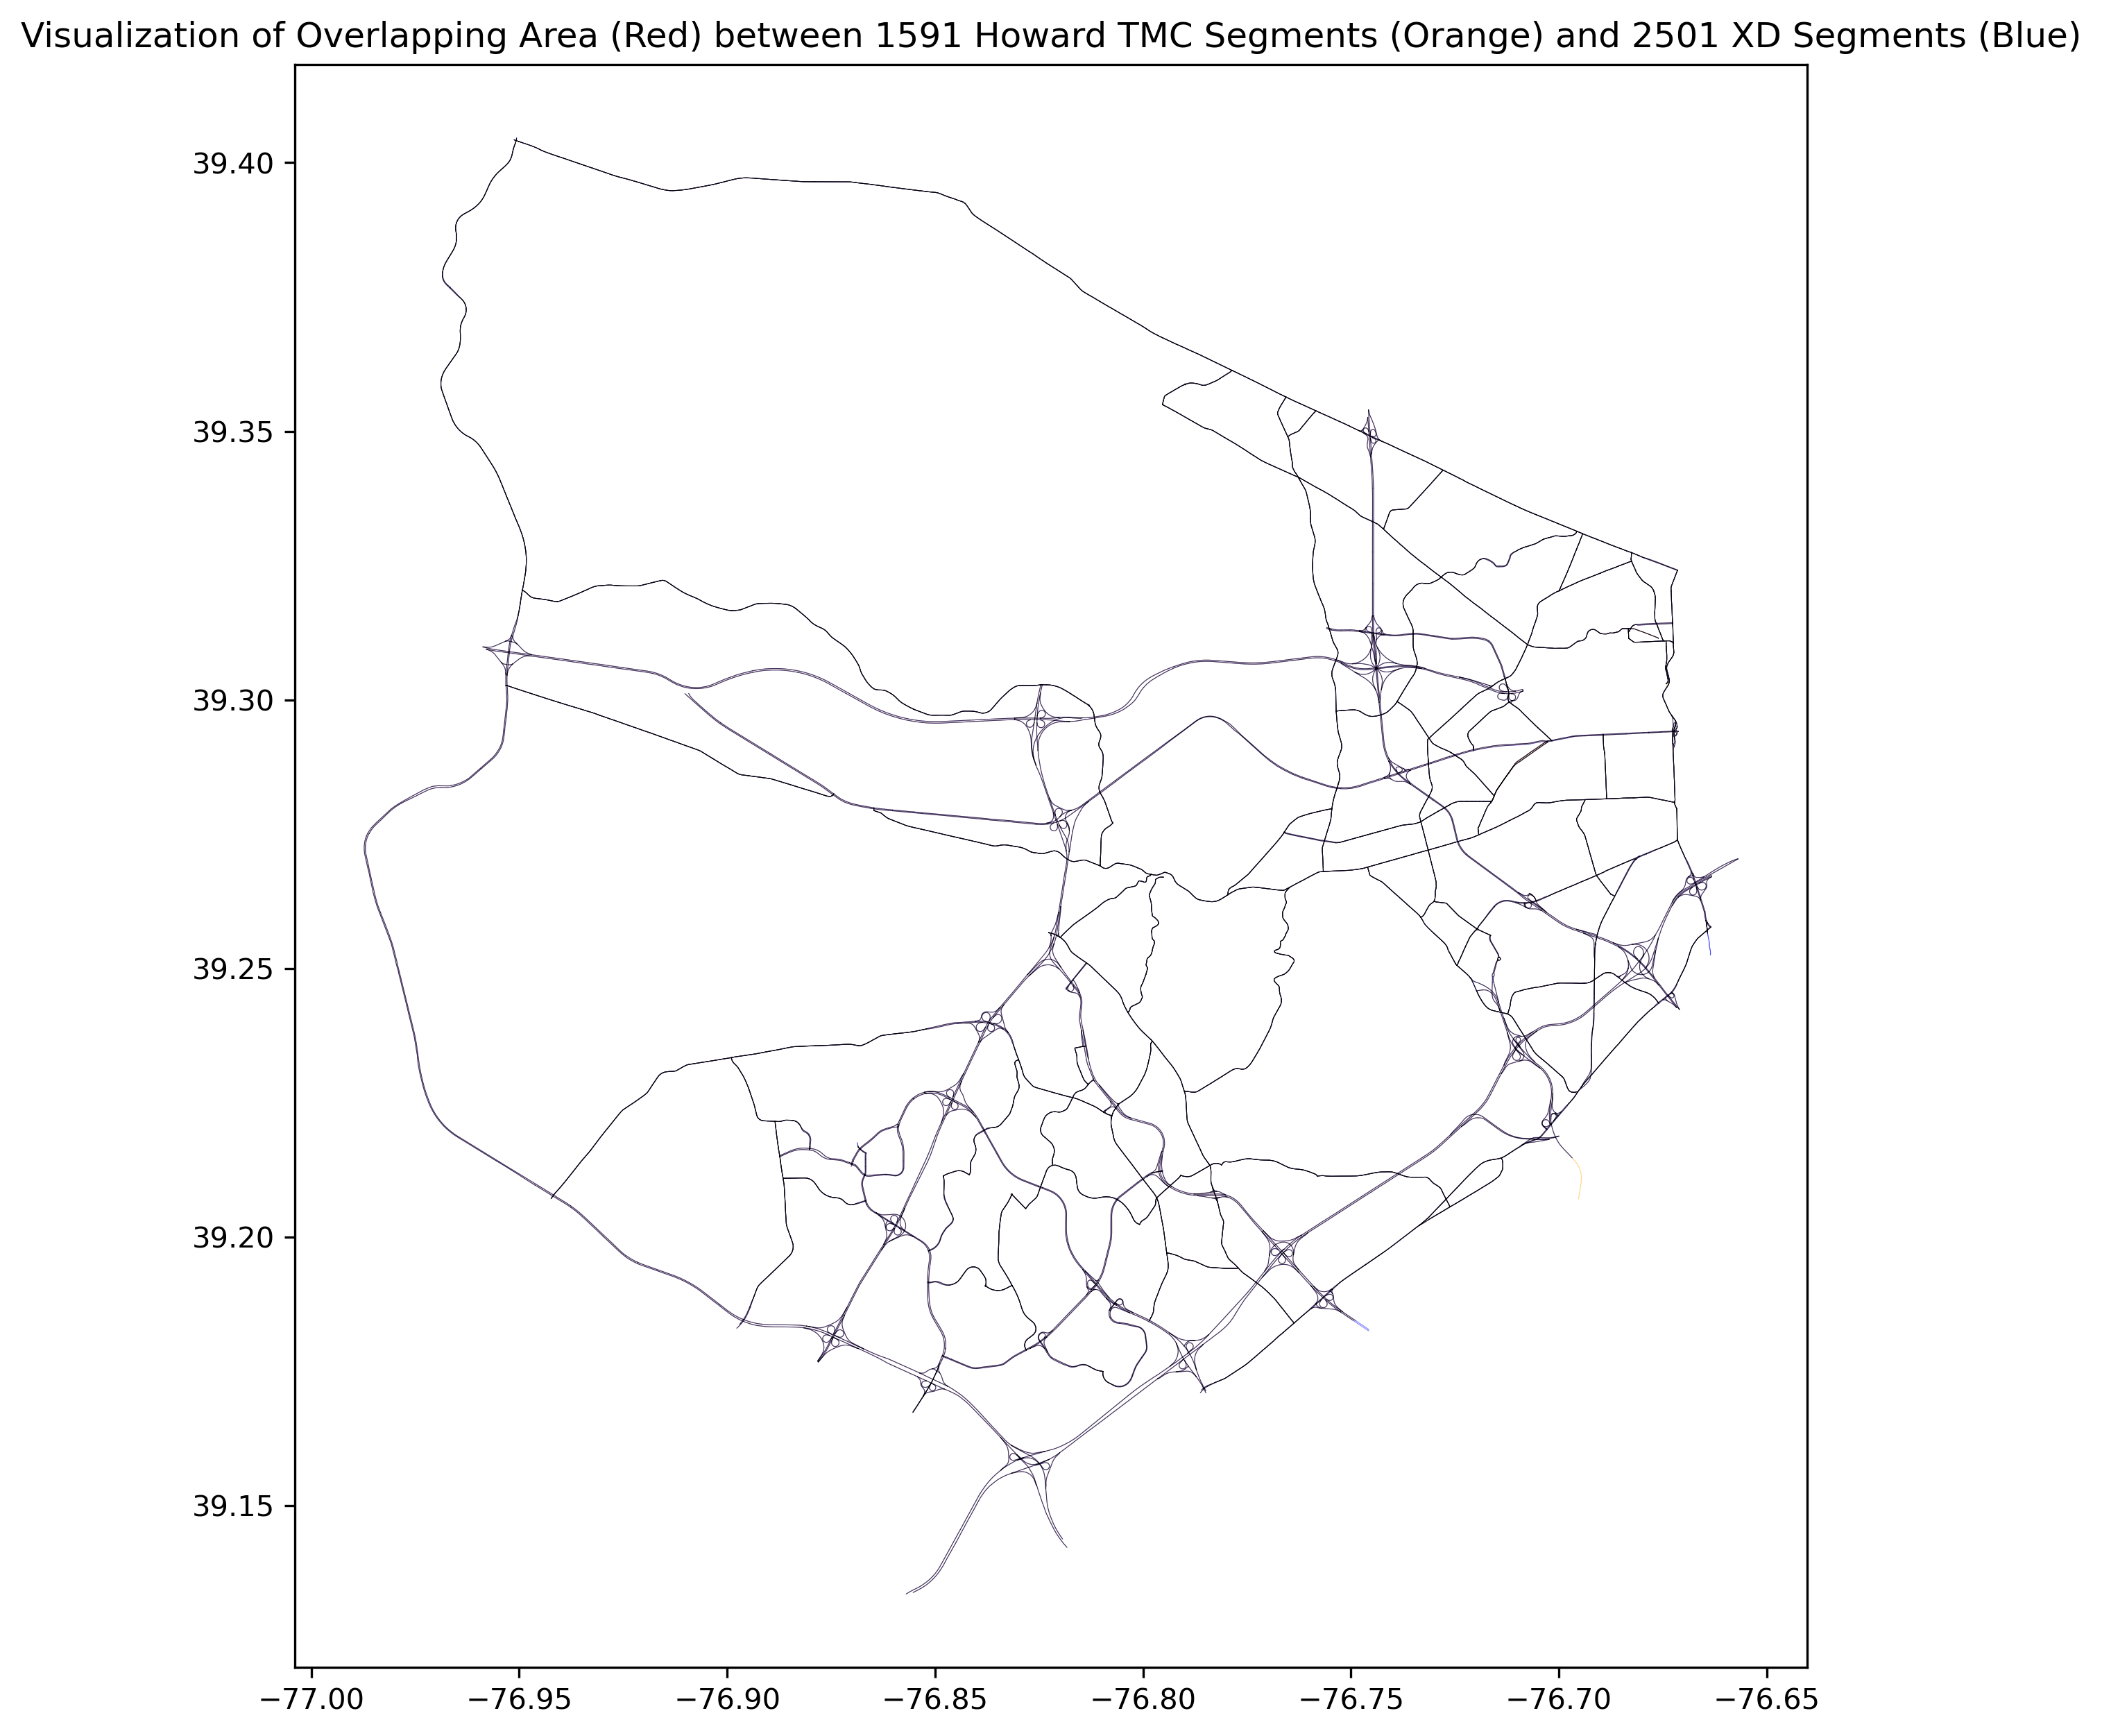

In [25]:
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of Overlapping Area (Red) between 1591 Howard TMC Segments (Orange) and 2501 XD Segments (Blue)")
gdf_TSMO_tmc_polygon.plot(ax=ax, color="orange", alpha=0.5)
gdf_TSMO_xd_polygon.plot(ax=ax, color="blue", alpha=0.5)
xd_to_tmc.plot(ax=ax, color="black", alpha=0.5)


In [27]:
'''
'tmc', 'miles_1', 'direction_1', 'type_x', 'type_y', 'road_order',
       'roadname_1', 'roadnumber', 'county_1', 'state_1', 'zip_1',
       'start_latitude_1', 'start_longitude_1', 'end_latitude_1',
       'end_longitude_1', 'layer_1', 'path_1', 'area_1', 'xd', 'miles_2',
       'direction_2', 'bearing', 'frc', 'roadname_2', 'roadnumer', 'county_2',
       'state_2', 'zip_2', 'start_latitude_2', 'start_longitude_2',
       'end_latitude_2', 'end_longitude_2', 'layer_2', 'path_2', 'area_2',
       'geometry', 'overlap_area'
'''
xd_to_tmc

,tmc,miles_1,direction_1,type_x,type_y,road_order,roadname_1,roadnumber,county_1,state_1,...,zip_2,start_latitude_2,start_longitude_2,end_latitude_2,end_longitude_2,layer_2,path_2,area_2,geometry,overlap_area
0,110-12744,1.070253,SOUTHBOUND,P1.11,Feature,1.000,HARPERS FARM RD,None,HOWARD,MD,...,21044,39.21515,-76.88737,39.22154,-76.88850,intermediate_xd_b&h,/Users/haowu/Desktop/Transportation Research/T...,11233.029878,"POLYGON ((-76.88841 39.22154, -76.88851 39.221...",142.684600
1,110-12743,0.695779,SOUTHBOUND,P1.11,Feature,2.000,HARPERS FARM RD,None,HOWARD,MD,...,21044,39.21515,-76.88737,39.22154,-76.88850,intermediate_xd_b&h,/Users/haowu/Desktop/Transportation Research/T...,11233.029878,"POLYGON ((-76.88850 39.22147, -76.88858 39.221...",153.479224
2,110N12733,0.042112,WESTBOUND,P1.11,Feature,10.001,LITTLE PATUXENT PKY,None,HOWARD,MD,...,21044,39.21515,-76.88737,39.22154,-76.88850,intermediate_xd_b&h,/Users/haowu/Desktop/Transportation Research/T...,11233.029878,"POLYGON ((-76.88740 39.21511, -76.88745 39.215...",158.495401
3,110+12749,0.418002,NORTHBOUND,P1.11,Feature,6.000,CEDAR LN,None,HOWARD,MD,...,21044,39.21515,-76.88737,39.22154,-76.88850,intermediate_xd_b&h,/Users/haowu/Desktop/Transportation Research/T...,11233.029878,"POLYGON ((-76.88753 39.21543, -76.88753 39.215...",10556.508450
4,110N12749,0.027096,SOUTHBOUND,P1.11,Feature,1.000,CEDAR LN,None,HOWARD,MD,...,21044,39.21515,-76.88737,39.22154,-76.88850,intermediate_xd_b&h,/Users/haowu/Desktop/Transportation Research/T...,11233.029878,"POLYGON ((-76.88835 39.22116, -76.88843 39.221...",796.394168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12703,110P06172,0.069794,WESTBOUND,P1.11,Feature,45.000,SYKESVILLE RD,MD-32,CARROLL,MD,...,21784,39.40356,-76.95097,39.39998,-76.95263,intermediate_xd_carroll,/Users/haowu/Desktop/Transportation Research/T...,6704.505389,"POLYGON ((-76.95099 39.40349, -76.95104 39.403...",128.498291
12704,110N06172,0.069794,EASTBOUND,P1.11,Feature,16.000,SYKESVILLE RD,MD-32,CARROLL,MD,...,21784,39.40356,-76.95097,39.39998,-76.95263,intermediate_xd_carroll,/Users/haowu/Desktop/Transportation Research/T...,6704.505389,"POLYGON ((-76.95099 39.40349, -76.95104 39.403...",128.498291
12705,110-06173,1.879434,EASTBOUND,P1.11,Feature,17.000,SYKESVILLE RD,MD-32,CARROLL,MD,...,21784,39.40356,-76.95097,39.39998,-76.95263,intermediate_xd_carroll,/Users/haowu/Desktop/Transportation Research/T...,6704.505389,"POLYGON ((-76.95109 39.40311, -76.95116 39.402...",6671.265894
12706,110+06172,1.879434,WESTBOUND,P1.11,Feature,44.000,SYKESVILLE RD,MD-32,CARROLL,MD,...,21784,39.39048,-76.96320,39.39998,-76.95263,intermediate_xd_carroll,/Users/haowu/Desktop/Transportation Research/T...,22111.087556,"POLYGON ((-76.96271 39.39076, -76.96247 39.390...",22111.087549


In [28]:
selected_xd_to_tmc = xd_to_tmc[["tmc", "xd", 'start_latitude_1', 'start_longitude_1', 'end_latitude_1', 'end_longitude_1', 'start_latitude_2', 'start_longitude_2', 'end_latitude_2', 'end_longitude_2', "direction_1", 'direction_2', 'area_1', 'area_2', 'overlap_area']]
selected_xd_to_tmc.columns = ["id_tmc", "id_xd", 'tmc_start_lat', 'tmc_start_long', 'tmc_end_lat', 'tmc_end_long', 'xd_start_lat', 'xd_start_long', 'xd_end_lat', 'xd_end_long', "direction_tmc", "direction_xd", 'area_tmc', 'area_xd', 'overlap_area']

# 3. Check on Overlapping Area

In [29]:
selected_xd_to_tmc["overlap_vs_tmc"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_tmc
selected_xd_to_tmc["overlap_vs_xd"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_xd

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_6541/321984553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_xd_to_tmc["overlap_vs_tmc"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_tmc
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_6541/321984553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_xd_to_tmc["overlap_vs_xd"] = selected_xd_to_tmc.overlap_area/selected_xd_to_tmc.area_xd


In [30]:
selected_xd_to_tmc.overlap_vs_tmc.describe(), selected_xd_to_tmc.overlap_vs_xd.describe()

(count    1.270800e+04
 mean     2.328181e-01
 std      3.193603e-01
 min      1.617202e-08
 25%      1.405722e-02
 50%      8.181697e-02
 75%      3.025888e-01
 max      1.000000e+00
 Name: overlap_vs_tmc, dtype: float64,
 count    1.270800e+04
 mean     3.461424e-01
 std      4.119255e-01
 min      1.617202e-08
 25%      1.951135e-02
 50%      1.015000e-01
 75%      9.330104e-01
 max      1.000000e+00
 Name: overlap_vs_xd, dtype: float64)

In [31]:
selected_xd_to_tmc

,id_tmc,id_xd,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,direction_tmc,direction_xd,area_tmc,area_xd,overlap_area,overlap_vs_tmc,overlap_vs_xd
0,110-12744,1310476479,39.23316,-76.89893,39.22154,-76.88850,39.21515,-76.88737,39.22154,-76.88850,SOUTHBOUND,N,26804.018980,11233.029878,142.684600,0.005323,0.012702
1,110-12743,1310476479,39.22154,-76.88850,39.21652,-76.88024,39.21515,-76.88737,39.22154,-76.88850,SOUTHBOUND,N,17453.115951,11233.029878,153.479224,0.008794,0.013663
2,110N12733,1310476479,39.21541,-76.88666,39.21515,-76.88737,39.21515,-76.88737,39.22154,-76.88850,WESTBOUND,N,1167.999997,11233.029878,158.495401,0.135698,0.014110
3,110+12749,1310476479,39.21515,-76.88737,39.22115,-76.88844,39.21515,-76.88737,39.22154,-76.88850,NORTHBOUND,N,10556.508450,11233.029878,10556.508450,1.000000,0.939774
4,110N12749,1310476479,39.22154,-76.88850,39.22115,-76.88844,39.21515,-76.88737,39.22154,-76.88850,SOUTHBOUND,N,796.394168,11233.029878,796.394168,1.000000,0.070898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12703,110P06172,449118308,39.40355,-76.95096,39.40452,-76.95065,39.40356,-76.95097,39.39998,-76.95263,WESTBOUND,S,1856.787085,6704.505389,128.498291,0.069205,0.019166
12704,110N06172,449118308,39.40452,-76.95065,39.40355,-76.95096,39.40356,-76.95097,39.39998,-76.95263,EASTBOUND,S,1856.787085,6704.505389,128.498291,0.069205,0.019166
12705,110-06173,449118308,39.40355,-76.95096,39.38106,-76.96788,39.40356,-76.95097,39.39998,-76.95263,EASTBOUND,S,46876.491952,6704.505389,6671.265894,0.142316,0.995042
12706,110+06172,449105852,39.38106,-76.96788,39.40355,-76.95096,39.39048,-76.96320,39.39998,-76.95263,WESTBOUND,N,46876.491952,22111.087556,22111.087549,0.471688,1.000000


0.012601
0.509710714741291
0.9999999999999999
0.03386975625432565


<AxesSubplot: title={'center': 'Visualization of Overlapping Area between TMC Segments (Orange) and XD Segments (Blue)'}>

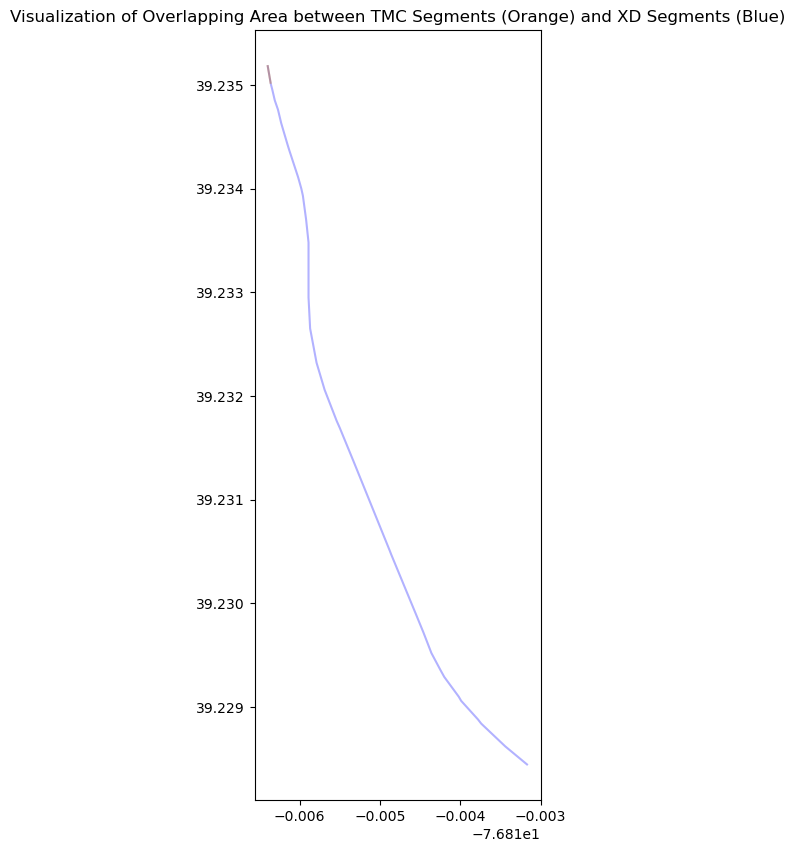

In [36]:
# viz of overlapping area
fig, ax = plt.subplots(1,figsize=(10,10))
ax.set_title("Visualization of Overlapping Area between TMC Segments (Orange) and XD Segments (Blue)")
curr_tmc = '110N55328'
curr_xd = 133248799
print(gdf_TSMO_tmc[gdf_TSMO_tmc.tmc == curr_tmc].miles.values[0])
print(gdf_TSMO_xd[gdf_TSMO_xd.xd == curr_xd].miles.values[0])
print(selected_xd_to_tmc[(selected_xd_to_tmc.id_tmc == curr_tmc) & (selected_xd_to_tmc.id_xd == curr_xd)].overlap_vs_tmc.values[0])
print(selected_xd_to_tmc[(selected_xd_to_tmc.id_tmc == curr_tmc) & (selected_xd_to_tmc.id_xd == curr_xd)].overlap_vs_xd.values[0])
gdf_TSMO_tmc[gdf_TSMO_tmc.tmc == curr_tmc].plot(ax=ax, color="orange", alpha=0.5)
gdf_TSMO_xd[gdf_TSMO_xd.xd == curr_xd].plot(ax=ax, color="blue", alpha=0.3)

In [37]:
# select matching where overlapping area account for at least 50% of TMC and/or XD segments
selected_xd_to_tmc = selected_xd_to_tmc[(selected_xd_to_tmc.overlap_vs_tmc >= 0.5) | (selected_xd_to_tmc.overlap_vs_xd >= 0.5)] # 1589 TMC, 2498 XD, shape (4307, 17)

# 4. Checking on Direction

In [41]:
# compute angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["direction_matchness"] = selected_xd_to_tmc.apply(lambda x: check_direction(x.direction_tmc, x.direction_xd), axis=1)
selected_xd_to_tmc = selected_xd_to_tmc[selected_xd_to_tmc.direction_matchness == 1].reset_index(drop=True) # 1557 TMC, 2451 XD, shape (3177, 19)
selected_xd_to_tmc["angle"] = selected_xd_to_tmc.apply(lambda x: angle(x.xd_start_lat, x.xd_start_long, x.tmc_start_lat, x.tmc_start_long, x.xd_end_lat, x.xd_end_long, x.tmc_end_lat, x.tmc_end_long), axis=1)

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_6541/1742388276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_xd_to_tmc["direction_matchness"] = selected_xd_to_tmc.apply(lambda x: check_direction(x.direction_tmc, x.direction_xd), axis=1)


In [45]:
# five number summary of angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["angle"].describe()

count    3177.000000
mean        0.154191
std         0.294709
min         0.000000
25%         0.001864
50%         0.020068
75%         0.106589
max         1.000000
Name: angle, dtype: float64

In [46]:
raw_xd_to_tmc = selected_xd_to_tmc[selected_xd_to_tmc.angle < 0.5] # 1556 TMC, 2448 xd ids, shape (2796, 19)

In [50]:
len(raw_xd_to_tmc.id_xd.unique())

2448

In [51]:
raw_xd_to_tmc.to_csv("./TSMO/raw_xd_to_tmc_TSMO.csv", index=False) # need further checking (step 5 below)

# 5. Manual Checking
- This step involves manual checking and comparison, the python script of which is covered in manual_check_TSMO.py
- The final tmc-xd matching result has been saved in "./TSMO/xd_to_tmc_TSMO.numbers" and "./TSMO/xd_to_tmc_TSMO.csv"

# 6. Save Final Result as Dictionary

In [70]:
final_xd_to_tmc = pd.read_csv("./TSMO/xd_to_tmc_TSMO.csv")

In [71]:
final_xd_to_tmc = final_xd_to_tmc.rename(columns={"id_xd":"id_xd_str"})
final_xd_to_tmc.id_xd_str = final_xd_to_tmc.id_xd_str.astype(str)

In [72]:
final_xd_to_tmc # 1555 TMC matched with 2427 XD, shape (2710, 20)

,Note,id_tmc,id_xd_str,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,direction_tmc,direction_xd,area_tmc,area_xd,overlap_area,overlap_vs_tmc,overlap_vs_xd,direction_matchness,angle
0,TMC面积过小,110P55328,134369646,39.23501,-76.81636,39.23519,-76.81640,39.22844,-76.81316,39.235190,-76.816400,NORTHBOUND,N,434.367950,12824.655339,434.367950,1.0,0.033870,True,0.072846
1,TMC面积过小,110P55327,134369646,39.22844,-76.81316,39.22862,-76.81344,39.22844,-76.81316,39.235190,-76.816400,NORTHBOUND,N,605.289902,12824.655339,605.289902,1.0,0.047197,True,0.175688
2,TMC面积过小,110P53871,1310557534,39.20541,-76.82837,39.20530,-76.82823,39.20785,-76.83142,39.205300,-76.828230,EASTBOUND,S,386.098617,6239.187204,386.098617,1.0,0.061883,True,0.002670
3,TMC面积过小,110P53864,1310518142,39.19096,-76.83165,39.19102,-76.83149,39.19087,-76.83776,39.191020,-76.831490,EASTBOUND,E,357.362258,9159.991430,357.362258,1.0,0.039013,True,0.106587
4,TMC面积过小,110P53860,1310290305,39.19150,-76.85155,39.19150,-76.85119,39.19150,-76.85155,39.192925,-76.843349,EASTBOUND,E,600.765871,12548.907533,600.765871,1.0,0.047874,True,0.054742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,NaN,110-04386,1310335166,39.18353,-76.89256,39.18313,-76.88159,39.18353,-76.89256,39.183130,-76.881590,EASTBOUND,S,14805.446801,14805.446801,14805.446801,1.0,1.000000,True,0.000000
2706,NaN,110-04385,1310594831,39.17926,-76.86845,39.17626,-76.86063,39.17926,-76.86845,39.174020,-76.854250,EASTBOUND,S,11783.252085,21141.817763,11783.252085,1.0,0.557343,True,0.004076
2707,NaN,110-04384,1310594831,39.17594,-76.85971,39.17402,-76.85425,39.17926,-76.86845,39.174020,-76.854250,EASTBOUND,S,8131.288334,21141.817763,8131.288318,1.0,0.384607,True,0.004892
2708,NaN,110-04383,1310382287,39.17173,-76.84781,39.16270,-76.83424,39.17173,-76.84781,39.162700,-76.834240,EASTBOUND,S,24271.593939,24271.593939,24271.593939,1.0,1.000000,True,0.000000


In [76]:
final_dict_xd_to_tmc = final_xd_to_tmc.groupby("id_tmc").apply(lambda x: x.id_xd_str.tolist()).to_dict()
final_dict_tmc_to_xd = final_xd_to_tmc.groupby("id_xd_str").apply(lambda x: x.id_tmc.tolist()).to_dict()

In [77]:
pickle.dump(final_xd_to_tmc, open("./TSMO/df_xd_to_tmc_TSMO.pkl", "wb"))
pickle.dump(final_dict_xd_to_tmc, open("./TSMO/dict_xd_to_tmc_TSMO.pkl", "wb"))
pickle.dump(final_dict_tmc_to_xd, open("./TSMO/dict_tmc_to_xd_TSMO.pkl", "wb"))

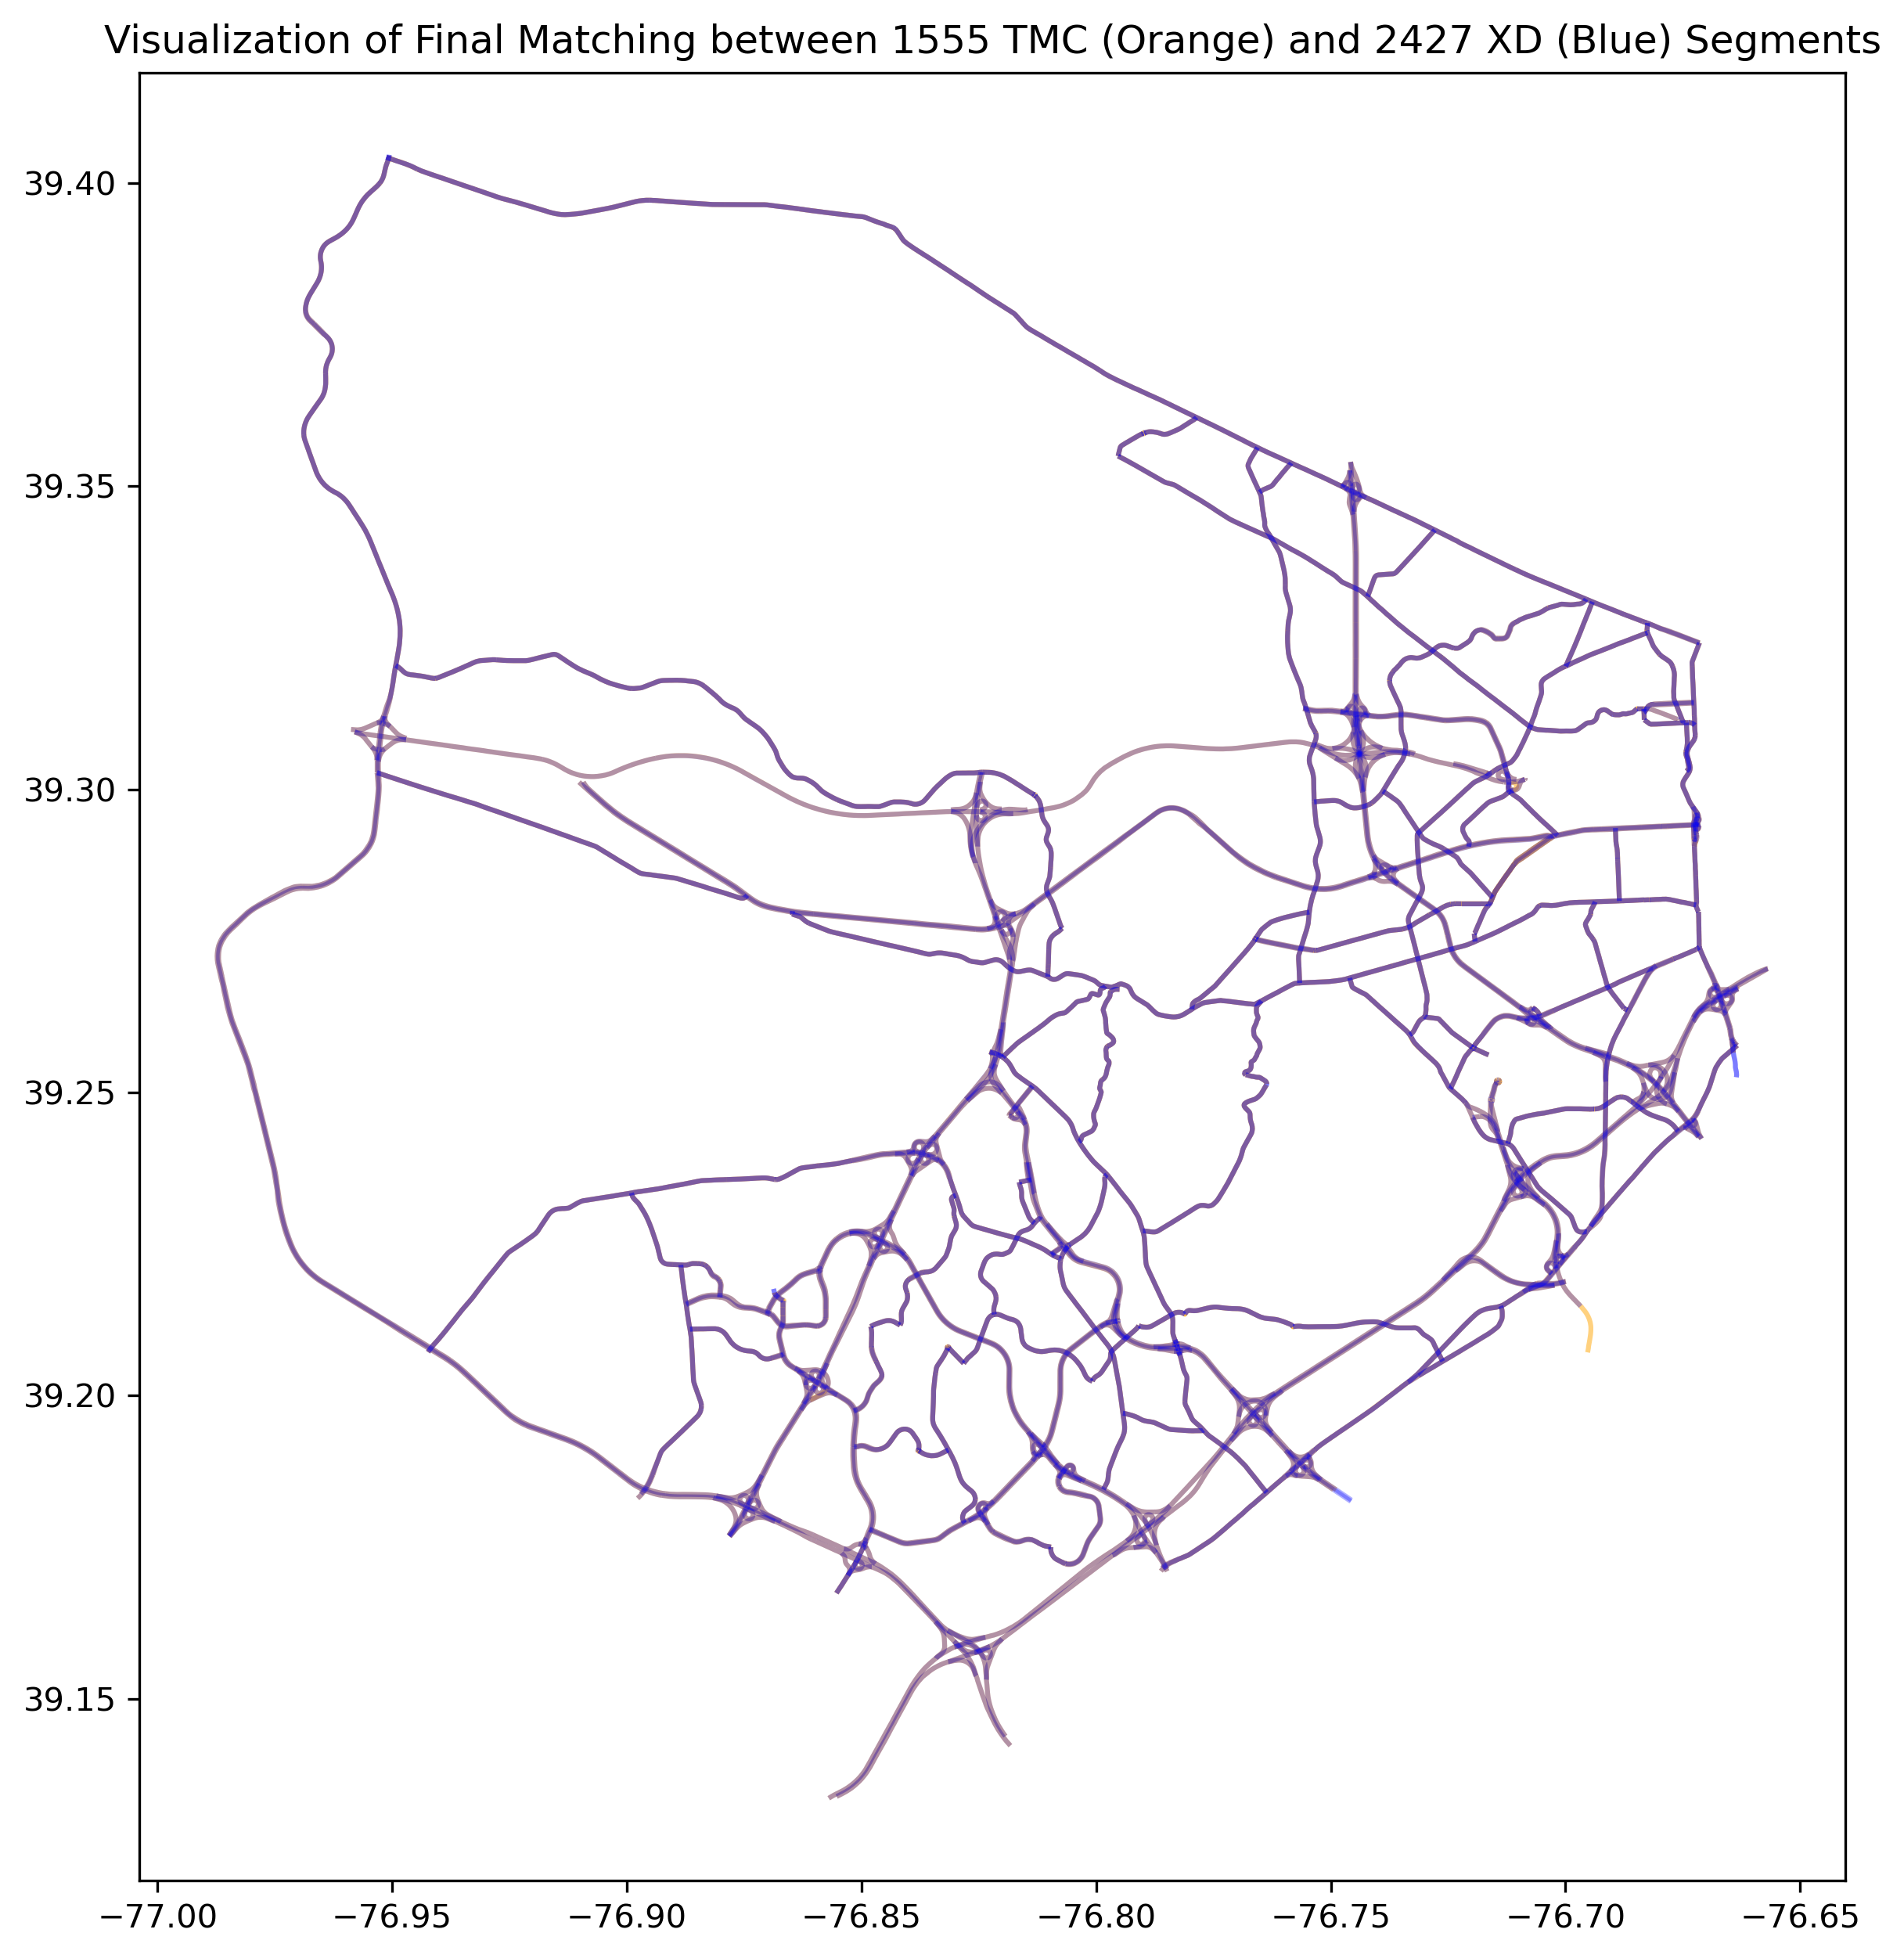

In [78]:
# Visualization of Matched 1555 TMC (Orange) and 2427 XD (Blue) Segments (Buffered with radius 10)
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of Final Matching between 1555 TMC (Orange) and 2427 XD (Blue) Segments")
gdf_TSMO_tmc[gdf_TSMO_tmc.tmc.isin(set(final_xd_to_tmc.id_tmc))].plot(ax=ax, color="orange", alpha=0.5)
gdf_TSMO_xd[gdf_TSMO_xd.xd.astype(str).isin(set(final_xd_to_tmc.id_xd_str))].plot(ax=ax, color="blue", alpha=0.3)
fig.savefig("./TSMO/viz_final_xd_to_tmc_TSMO.jpg")